In this base model of logistic regression, raw dataset from training.csv file has been used, without any feature engineering and only standard scaling has been performed as it's necessary for modeling.

The Number of features we used for this base model are limited, only:

ProviderId, ProductId, ProductCategory, ChannelId, Amount, PricingStrategy

### Import some Libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, ConfusionMatrixDisplay

import warnings

# Set random seed 
RSEED = 42

In [2]:
# Load data
df = pd.read_csv('../data/training.csv', parse_dates=['TransactionStartTime']).drop(['CountryCode', 'CurrencyCode'], axis=1)

In [3]:
df.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15 02:18:49+00:00,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15 02:19:08+00:00,2,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15 02:44:21+00:00,2,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15 03:32:55+00:00,2,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15 03:34:21+00:00,2,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95662 entries, 0 to 95661
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   TransactionId         95662 non-null  object             
 1   BatchId               95662 non-null  object             
 2   AccountId             95662 non-null  object             
 3   SubscriptionId        95662 non-null  object             
 4   CustomerId            95662 non-null  object             
 5   ProviderId            95662 non-null  object             
 6   ProductId             95662 non-null  object             
 7   ProductCategory       95662 non-null  object             
 8   ChannelId             95662 non-null  object             
 9   Amount                95662 non-null  float64            
 10  Value                 95662 non-null  int64              
 11  TransactionStartTime  95662 non-null  datetime64[ns, UTC]
 12  Pric

In [5]:
df.nunique()

TransactionId           95662
BatchId                 94809
AccountId                3633
SubscriptionId           3627
CustomerId               3742
ProviderId                  6
ProductId                  23
ProductCategory             9
ChannelId                   4
Amount                   1676
Value                    1517
TransactionStartTime    94556
PricingStrategy             4
FraudResult                 2
dtype: int64

In [6]:
#selecting features for baseline model
features = ['ProviderId', 'ProductId', 'ProductCategory', 'ChannelId', 'Amount', 'PricingStrategy', 'FraudResult']
df_base = df[features]
df_base.head()

,ProviderId,ProductId,ProductCategory,ChannelId,Amount,PricingStrategy,FraudResult
0,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,2,0
1,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,2,0
2,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,2,0
3,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,2,0
4,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,2,0


In [7]:
# Creating separate lists for numerical and categorical predictors 
cat_features = list(df_base.columns[df_base.dtypes==object])
num_features = list(df_base.columns[df_base.dtypes!=object])
num_features.remove('FraudResult')

In [8]:
print(cat_features)
print(num_features)

['ProviderId', 'ProductId', 'ProductCategory', 'ChannelId']
['Amount', 'PricingStrategy']


In [9]:
categorical_transformer = OneHotEncoder(handle_unknown="ignore")
numeric_transformer = StandardScaler()
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, cat_features),
        ("num", numeric_transformer, num_features)
    ]
)

In [10]:
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000, class_weight="balanced"))
])


In [11]:
# Define predictors and target variable
X = df_base[features].drop('FraudResult', axis=1)
y = df_base['FraudResult']

# Split into train and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RSEED, stratify=y)

In [12]:
model.fit(X_train, y_train)

print("Train score:", model.score(X_train, y_train))
print("Test score:", model.score(X_test, y_test))

Train score: 0.9450796430111461
Test score: 0.9454868551716928


In [13]:
y_train_predicted = cross_val_predict(model, X_train, y_train, cv=5)

In [14]:
# Calculating the accuracy for the LogisticRegression Classifier 
print('Cross validation scores:')
print('-------------------------')
print("Accuracy: {:.2f}".format(accuracy_score(y_train, y_train_predicted)))
print("Recall: {:.2f}".format(recall_score(y_train, y_train_predicted)))
print("F1-score: {:.2f}".format(f1_score(y_train, y_train_predicted)))

Cross validation scores:
-------------------------
Accuracy: 0.96
Recall: 0.95
F1-score: 0.08


In [15]:
confusion_matrix(y_train, y_train_predicted)


array([[73026,  3349],
       [    7,   147]])

In [16]:
y_test_predicted = cross_val_predict(model, X_test, y_test, cv=5)

# Calculating the accuracy for the LogisticRegression Classifier 
print('Cross validation scores:')
print('-------------------------')
print("Accuracy: {:.2f}".format(accuracy_score(y_test, y_test_predicted)))
print("Recall: {:.2f}".format(recall_score(y_test, y_test_predicted)))
print("F1-score: {:.2f}".format(f1_score(y_test, y_test_predicted)))

Cross validation scores:
-------------------------
Accuracy: 0.99
Recall: 0.95
F1-score: 0.25


In [17]:
confusion_matrix(y_test, y_test_predicted)

array([[18874,   220],
       [    2,    37]])

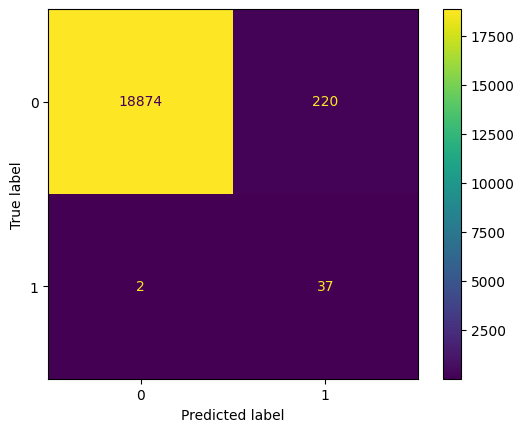

In [18]:
# confusion matrix display
conf_mat = confusion_matrix(y_test, y_test_predicted)
disp = (ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                               display_labels=model.classes_))
disp.plot();